<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/MDF/blob/main/MDF_Transporte_de_esp%C3%A9cies_com_Navier_Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iniciando simulação...
  ... salvando resultado no passo 0 (T = 0.00s)
  ... salvando resultado no passo 2500 (T = 5.00s)
  ... salvando resultado no passo 5000 (T = 10.00s)
  ... salvando resultado no passo 7500 (T = 15.00s)
  ... salvando resultado no passo 9999 (T = 20.00s)
Simulação concluída.
Gerando visualização melhorada...


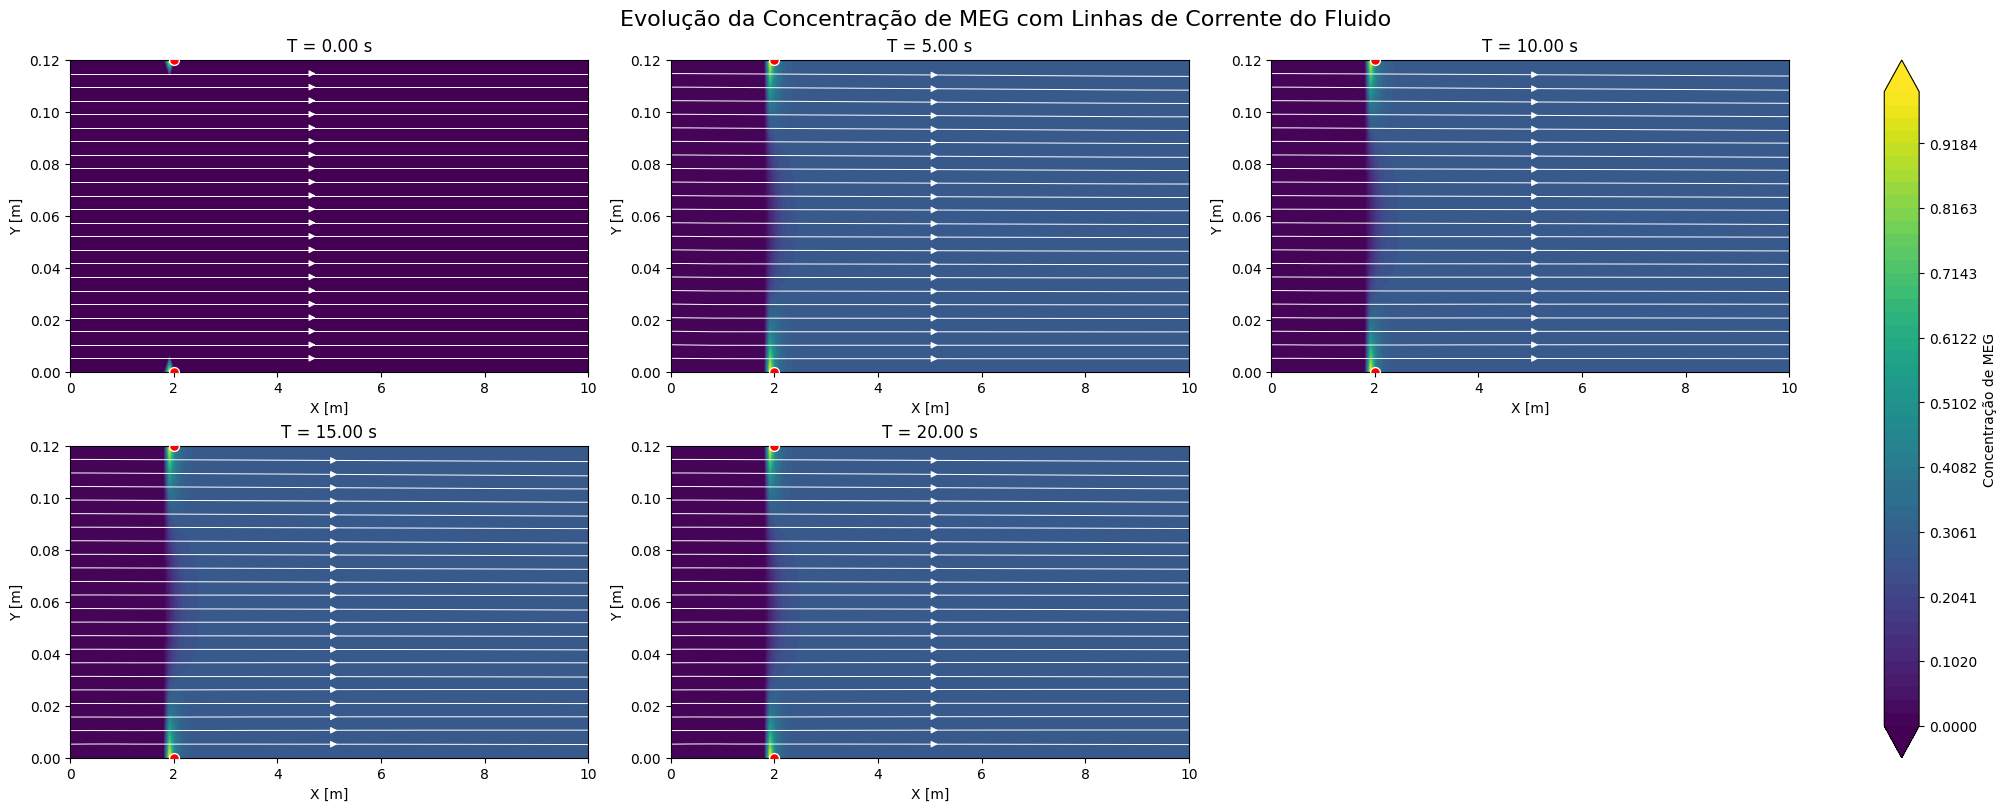

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parâmetros da Simulação ---
Lx, Ly = 10.0, 0.12     # Dimensões do domínio [m]
Tmax = 20.0             # Tempo total de simulação [s]
Nx, Ny = 100, 20        # Número de pontos na malha
Nt = 10000              # Número de passos no tempo

# Discretização
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
dt = Tmax / Nt
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

# --- 2. Propriedades do Fluido e do Contaminante ---
rho = 1000.0  # Densidade da água [kg/m^3]
mu = 1e-3     # Viscosidade dinâmica da água [Pa.s]
nu = mu / rho # Viscosidade cinemática [m^2/s]
D = 7.48e-3   # Coeficiente de difusão do MEG [m^2/s]

# --- 3. Condições Iniciais e de Contorno ---
u_inlet = 2.21
u = np.zeros((Ny, Nx))
v = np.zeros((Ny, Nx))
p = np.zeros((Ny, Nx))
c = np.zeros((Ny, Nx)) # Concentração de MEG

u[:, :] = u_inlet
x_inj_loc = 2.0
x_inj_index = int(x_inj_loc / dx)

# --- Funções do Solver (Método de Projeção) ---
def etapa_predicao(u, v, dt, dx, dy, nu):
    un, vn = u.copy(), v.copy()
    u_star, v_star = u.copy(), v.copy()
    adv_u = u[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[1:-1, 0:-2]) / dx + \
            v[1:-1, 1:-1] * (un[1:-1, 1:-1] - un[0:-2, 1:-1]) / dy
    adv_v = u[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) / dx + \
            v[1:-1, 1:-1] * (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) / dy
    lap_u = (un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, 0:-2]) / dx**2 + \
            (un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[0:-2, 1:-1]) / dy**2
    lap_v = (vn[1:-1, 2:] - 2*vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) / dx**2 + \
            (vn[2:, 1:-1] - 2*vn[1:-1, 1:-1] + vn[0:-2, 1:-1]) / dy**2
    u_star[1:-1, 1:-1] = un[1:-1, 1:-1] + dt * (-adv_u + nu * lap_u)
    v_star[1:-1, 1:-1] = vn[1:-1, 1:-1] + dt * (-adv_v + nu * lap_v)
    return u_star, v_star

def resolucao_pressao(p, rho, dt, dx, dy, u_star, v_star, max_iter=50):
    pn = p.copy()
    div_u_star = ((u_star[1:-1, 2:] - u_star[1:-1, 0:-2]) / (2 * dx) +
                  (v_star[2:, 1:-1] - v_star[0:-2, 1:-1]) / (2 * dy))
    rhs = (rho / dt) * div_u_star
    for _ in range(max_iter):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                         (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2 -
                         rhs * dx**2 * dy**2) /
                        (2 * (dx**2 + dy**2)))
        p[:, -1] = p[:, -2]
        p[0, :] = p[1, :]
        p[-1, :] = p[-2, :]
        p[:, 0] = p[:, 1]
    return p

def etapa_correcao(u, v, p, rho, dt, dx, dy, u_star, v_star):
    u_next, v_next = u.copy(), v.copy()
    dpdx = (p[1:-1, 2:] - p[1:-1, 0:-2]) / (2 * dx)
    dpdy = (p[2:, 1:-1] - p[0:-2, 1:-1]) / (2 * dy)
    u_next[1:-1, 1:-1] = u_star[1:-1, 1:-1] - (dt / rho) * dpdx
    v_next[1:-1, 1:-1] = v_star[1:-1, 1:-1] - (dt / rho) * dpdy
    u_next[:, 0] = u_inlet
    v_next[:, 0] = 0
    u_next[:, -1] = u_next[:, -2]
    v_next[:, -1] = v_next[:, -2]
    u_next[0, :] = 0.0
    v_next[0, :] = 0.0
    u_next[-1, :] = 0.0
    v_next[-1, :] = 0.0
    return u_next, v_next

def atualiza_concentracao(c, u, v, D, dt, dx, dy):
    cn = c.copy()
    c_new = c.copy()
    adv_x = u[1:-1, 1:-1] * (cn[1:-1, 1:-1] - cn[1:-1, 0:-2]) / dx
    adv_y = v[1:-1, 1:-1] * (cn[1:-1, 1:-1] - cn[0:-2, 1:-1]) / dy
    diff_x = D * (cn[1:-1, 2:] - 2*cn[1:-1, 1:-1] + cn[1:-1, 0:-2]) / dx**2
    diff_y = D * (cn[2:, 1:-1] - 2*cn[1:-1, 1:-1] + cn[0:-2, 1:-1]) / dy**2
    c_new[1:-1, 1:-1] = cn[1:-1, 1:-1] + dt * (-adv_x - adv_y + diff_x + diff_y)
    c_new[:, 0] = 0.0
    c_new[:, -1] = c_new[:, -2]
    c_new[0, :] = c_new[1, :]
    c_new[-1, :] = c_new[-2, :]
    c_new[0, x_inj_index] = 1.0
    c_new[-1, x_inj_index] = 1.0
    return c_new

# --- 4. Loop Principal da Simulação ---
results = []
save_steps = [0, int(0.25 * Nt), int(0.5 * Nt), int(0.75 * Nt), Nt - 1]

print("Iniciando simulação...")
for n in range(Nt):
    u_star, v_star = etapa_predicao(u, v, dt, dx, dy, nu)
    p = resolucao_pressao(p, rho, dt, dx, dy, u_star, v_star)
    u, v = etapa_correcao(u, v, p, rho, dt, dx, dy, u_star, v_star)
    c = atualiza_concentracao(c, u, v, D, dt, dx, dy)

    # ### ALTERAÇÃO AQUI: Salvar c, u, e v ###
    if n in save_steps:
        # Salva os três campos em um dicionário para cada passo
        results.append({'c': c.copy(), 'u': u.copy(), 'v': v.copy()})
        print(f"  ... salvando resultado no passo {n} (T = {n*dt:.2f}s)")

print("Simulação concluída.")


# --- 5. Visualização dos Resultados (VERSÃO MELHORADA) ---
print("Gerando visualização melhorada...")
# Organiza os plots em uma grade 2x3
fig, axes = plt.subplots(2, 3, figsize=(20, 8), constrained_layout=True)
axes = axes.flatten() # Transforma a matriz de eixos em um array 1D

# Níveis de contorno para a concentração
levels = np.linspace(0, 1.0, 50)

for i, data in enumerate(results):
    ax = axes[i]
    c_result = data['c']
    u_result = data['u']
    v_result = data['v']

    # Plota o campo de concentração com contornos preenchidos
    cf = ax.contourf(X, Y, c_result, levels=levels, cmap='viridis', extend='both')

    # Plota as linhas de corrente (streamlines) para visualizar o escoamento
    # A densidade controla o quão "cheio" o gráfico fica com as linhas
    ax.streamplot(X, Y, u_result, v_result, color='white', linewidth=0.7, density=0.8)

    # Marca os pontos de injeção para clareza
    ax.scatter([x_inj_loc, x_inj_loc], [y[0], y[-1]], color='red', edgecolor='white', s=50, zorder=5, label='Injeção')

    ax.set_title(f'T = {save_steps[i]*dt:.2f} s')
    ax.set_ylabel('Y [m]')
    ax.set_xlabel('X [m]')
    # Não força mais o 'aspect=equal'

# Apaga o último eixo que não foi usado
fig.delaxes(axes[5])

# Adiciona uma única barra de cores para toda a figura
cbar = fig.colorbar(cf, ax=axes, orientation='vertical', label='Concentração de MEG')

# Adiciona um título geral para a figura
fig.suptitle('Evolução da Concentração de MEG com Linhas de Corrente do Fluido', fontsize=16)

plt.show()

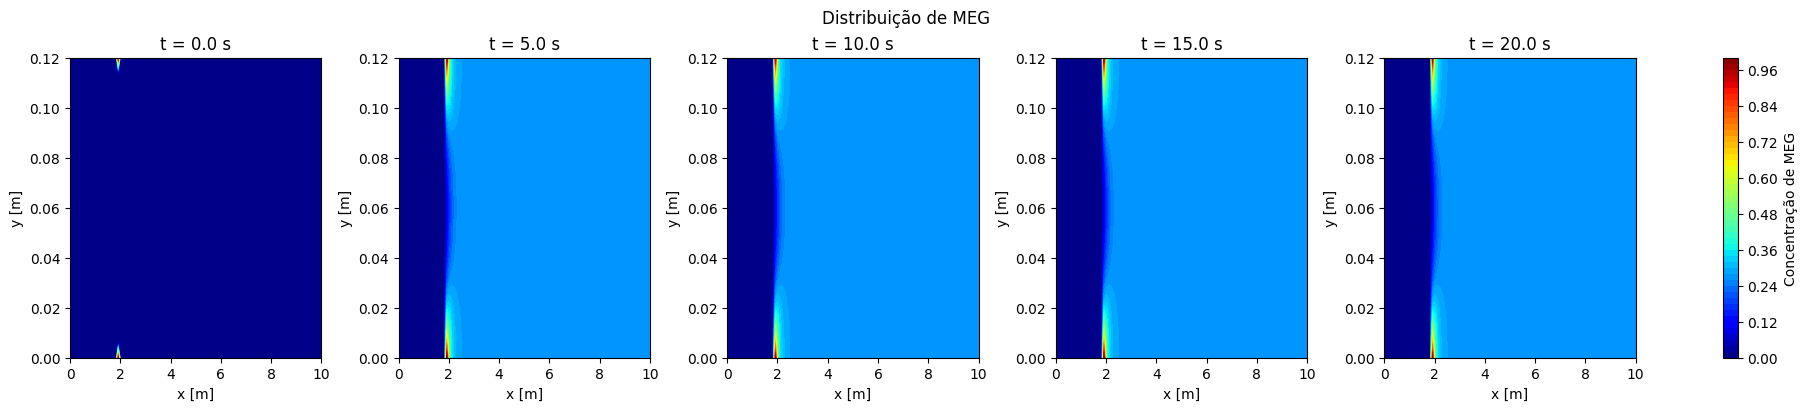

In [ ]:
fig, axes = plt.subplots(1, len(results), figsize=(18, 4), constrained_layout=True)
for idx, ax in enumerate(axes):
  cf = ax.contourf(X, Y, results[idx], levels=50, cmap='jet')
  ax.set_title(f"t = {save_steps[idx]*dt:.1f} s")
  ax.set_xlabel("x [m]")
  ax.set_ylabel("y [m]")
fig.colorbar(cf, ax=axes.ravel().tolist(), label='Concentração de MEG')
plt.suptitle("Distribuição de MEG")
plt.show()

In [29]:
#Imports
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax

N_b = 400
N_r = 15000

ymin, ymax = 0., 0.12
xmin, xmax = 0., 10.
tmin, tmax = 0., 10.

lb = jnp.array([xmin, ymin, tmin])
ub = jnp.array([xmax, ymax, tmax])

T = 352.89 #K
v = 2.21 #m/s
psimeg = 2.6 #parametro do solvente
Mmeg = 1.98+2*5.48 #Peso molecular do meg, em g/mol
mi = 0.891 #Viscosidade da solução, centipoises
Va = 55.7582 #Volume molar do soluto, em cm³/g*mol
#Difu = 7.4e-8 *((np.sqrt(psimeg*Mmeg)*T)/(mi*Va**0.6))
Difu = 7.4e-3
rhoagua = 1000
rhomeg = 1200
visccinagua = 0.89e-3
visccinmeg = 16.1e-3

b01, bk1, bk2, bk3, bk4, r0k, r1k, r2k = jax.random.split(jax.random.PRNGKey(0),8)

#Condição inicial
# Funções para definir condições iniciais e de contorno
def c_contorno(t, x, y):
  c_meg = jnp.zeros_like(x)
  c_agua = jnp.ones_like(x)
  u_agua = jnp.ones_like(x)*2.21
  v_agua = jnp.zeros_like(x)
  p_agua = jnp.ones_like(x)*10.0
  return c_meg, u_agua, v_agua, p_agua

def c_inicial(x, y):
  c_meg = jnp.zeros_like(x)
  c_agua = jnp.ones_like(x)
  u_agua = jnp.ones_like(x)*2.21
  v_agua = jnp.zeros_like(x)
  p_agua = jnp.ones_like(x)*10.0
  return c_meg, u_agua, v_agua, p_agua

def injecao(t, x, y):
  c_meg_inj = jnp.where(y == 0.0, 1.0, 0.0) + jnp.where(y == 0.12, 1.0, 0.0)
  c_agua_inj = 1.0 - c_meg_inj
  u_agua_inj = jnp.ones_like(x) * 2.21
  v_agua_inj = jnp.ones_like(x) * 2.21
  p_agua_inj = jnp.ones_like(x) * 7.0
  return c_meg_inj, u_agua_inj, v_agua_inj, p_agua_inj

# Geração dos pontos de condição inicial
x0 = jax.random.uniform(jax.random.PRNGKey(0), (N_b, 1), minval=lb[0], maxval=ub[0])
y0 = jax.random.uniform(jax.random.PRNGKey(1), (N_b, 1), minval=lb[1], maxval=ub[1])
t0 = jnp.zeros((N_b, 1))
c0meg, u0, v0, p0 = c_inicial(x0, y0)
espaco0 = jnp.concatenate([x0, y0, t0], axis=1)

# Geração dos pontos de contorno x=0
tbx1 = jax.random.uniform(jax.random.PRNGKey(2), (N_b, 1), minval=lb[2], maxval=ub[2])
xbx1 = jnp.zeros((N_b, 1))
ybx1 = jax.random.uniform(jax.random.PRNGKey(3), (N_b, 1), minval=lb[1], maxval=ub[1])
c_contxmeg, uc, vc, pc = c_contorno(tbx1, xbx1, ybx1)
espacobx1 = jnp.concatenate([xbx1, ybx1, tbx1], axis=1)

# Geração dos pontos de contorno x=1
tbx2 = jax.random.uniform(jax.random.PRNGKey(4), (N_b, 1), minval=lb[2], maxval=ub[2])
xbx2 = jnp.ones((N_b, 1)) * ub[0]
ybx2 = jax.random.uniform(jax.random.PRNGKey(5), (N_b, 1), minval=lb[1], maxval=ub[1])
espacobx2 = jnp.concatenate([xbx2, ybx2, tbx2], axis=1)
p_saida = jnp.zeros_like(xbx2)

# Geração dos pontos de contorno y=0
tby1 = jax.random.uniform(jax.random.PRNGKey(6), (N_b, 1), minval=lb[2], maxval=ub[2])
xby1 = jax.random.uniform(jax.random.PRNGKey(7), (N_b, 1), minval=lb[0], maxval=ub[0])
yby1 = jnp.zeros((N_b, 1))
espacoby1 = jnp.concatenate([xby1, yby1, tby1], axis=1)
uy0 = jnp.zeros_like(yby1)
vy0 = jnp.zeros_like(yby1)

# Geração dos pontos de contorno y=1
tby2 = jax.random.uniform(jax.random.PRNGKey(8), (N_b, 1), minval=lb[2], maxval=ub[2])
xby2 = jax.random.uniform(jax.random.PRNGKey(9), (N_b, 1), minval=lb[0], maxval=ub[0])
yby2 = jnp.ones((N_b, 1)) * ub[1]
espacoby2 = jnp.concatenate([xby2, yby2, tby2], axis=1)
uyfim = jnp.zeros_like(yby2)
vyfim = jnp.zeros_like(yby2)

#injeção de meg
tinj = jax.random.uniform(jax.random.PRNGKey(10), (N_b, 1), minval=lb[2], maxval=ub[2])
xinj = jnp.ones((N_b, 1)) * 2.0
yinj = 0.0 + jax.random.bernoulli(jax.random.PRNGKey(11), p=0.5, shape=(N_b, 1)) * 0.12
espacoinj = jnp.concatenate([xinj, yinj, tinj], axis=1)
c_meg_inj, ui, vi, pi = injecao(tinj, xinj, yinj)

#collocation points
t_c = jax.random.uniform(r0k,minval=tmin,maxval=tmax,shape=(N_r,1))
y_c = jax.random.uniform(r1k,minval=ymin,maxval=ymax,shape=(N_r,1))
x_c = jax.random.uniform(r2k,minval=xmin,maxval=xmax,shape=(N_r,1))
colloc = jnp.concatenate([x_c,y_c, t_c],axis=1)

def PDE_loss(x, y, t, c_meg, u, v, p):
  c_meg_x=lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(c_meg(x,y,t)),0)(x,y,t)
  c_meg_xx=lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(c_meg_x(x,y,t)),0)(x,y,t)

  c_meg_y=lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(c_meg(x,y,t)),1)(x,y,t)
  c_meg_yy=lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(c_meg_y(x,y,t)),1)(x,y,t)

  c_meg_t = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(c_meg(x,y,t)),2)(x,y,t)

  u_x = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(u(x,y,t)),0)(x,y,t)
  u_xx = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(u_x(x,y,t)),0)(x,y,t)

  u_y = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(u(x,y,t)),1)(x,y,t)
  u_yy = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(u_y(x,y,t)),1)(x,y,t)

  u_t = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(u(x,y,t)),2)(x,y,t)

  v_x = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(v(x,y,t)),0)(x,y,t)
  v_xx = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(v_x(x,y,t)),0)(x,y,t)

  v_y = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(v(x,y,t)),1)(x,y,t)
  v_yy = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(v_y(x,y,t)),1)(x,y,t)

  v_t = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(v(x,y,t)),2)(x,y,t)

  p_x = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(p(x,y,t)),0)(x,y,t)

  p_y = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(p(x,y,t)),1)(x,y,t)

  continuity = u_x(x,y,t) + v_y(x,y,t)
  momentum_x = u_t(x,y,t) + u(x,y,t)* u_x(x,y,t) + v(x,y,t) * u_y(x,y,t) + p_x(x,y,t)/((1-c_meg(x,y,t))*rhoagua + rhomeg*c_meg(x,y,t)) - ((1-c_meg(x,y,t))*visccinagua + visccinmeg*c_meg(x,y,t)) * (u_xx(x,y,t) + u_yy(x,y,t))
  momentum_y = v_t(x,y,t) + u(x,y,t)* v_x(x,y,t) + v(x,y,t) * v_y(x,y,t) + p_y(x,y,t)/((1-c_meg(x,y,t))*rhoagua + rhomeg*c_meg(x,y,t)) - ((1-c_meg(x,y,t))*visccinagua + visccinmeg*c_meg(x,y,t)) * (v_xx(x,y,t) + v_yy(x,y,t))
  transport = c_meg_t(x,y,t) + u(x,y,t)*(c_meg_x(x,y,t)) + v(x,y,t)*(c_meg_y(x,y,t)) -Difu*(c_meg_xx(x,y,t) + c_meg_yy(x,y,t))

  return continuity + momentum_x + momentum_y + transport

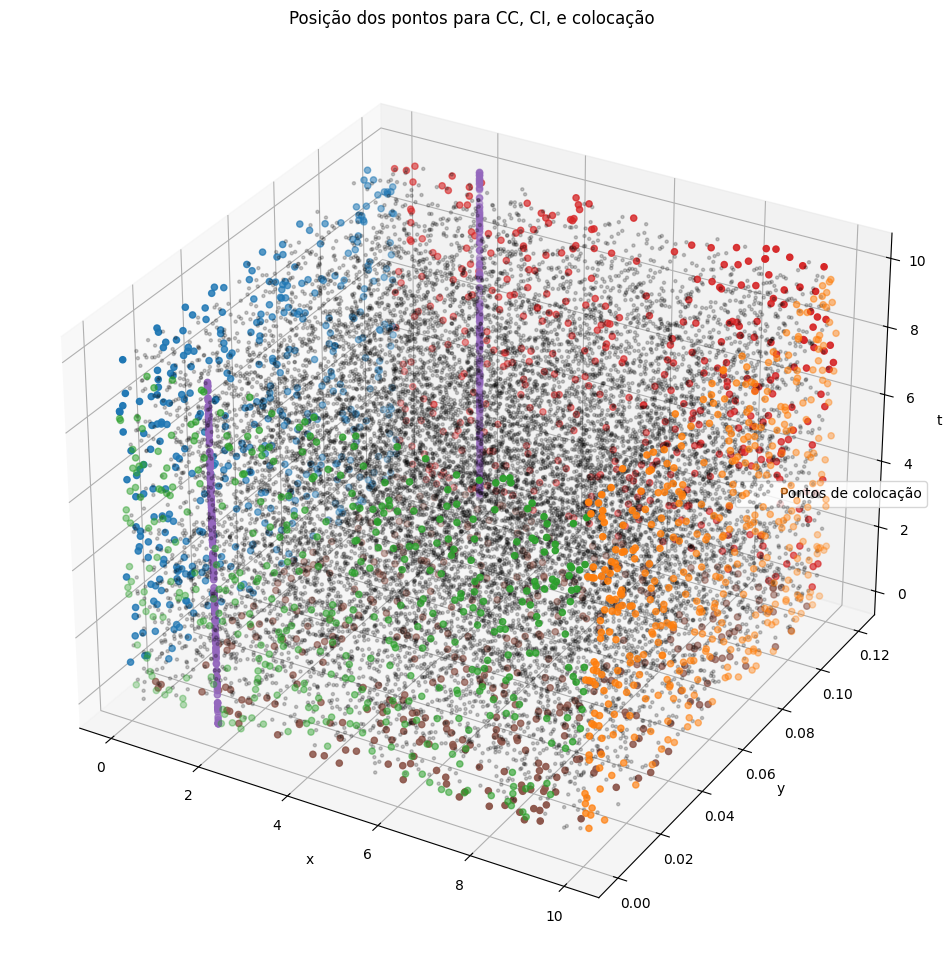

In [30]:
# Configuração da figura 3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
# Gráficos de dispersão para as diferentes condições de contorno e pontos de colocation
scatter1 = ax.scatter(xbx1, ybx1, tbx1)
scatter2 = ax.scatter(xbx2, ybx2, tbx2)
scatter3 = ax.scatter(xby1, yby1, tby1)
scatter4 = ax.scatter(xby2, yby2, tby2)
scatter4 = ax.scatter(xinj, yinj, tinj)
scatter0 = ax.scatter(x0,y0,t0)

# Pontos de colocation em preto
ax.scatter(x_c, y_c, t_c, c='k', marker='.', alpha=0.2, label='Pontos de colocação')

# Ajustes do gráfico
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
ax.set_title('Posição dos pontos para CC, CI, e colocação')

# Barra de cores e legenda
norm = mpl.colors.Normalize(vmin=0, vmax=1)
ax.legend(loc='center right')

plt.show()

In [31]:
def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(30),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

def fwd(params, x, y, t):
  # Concatenar t, x e y para formar o input da rede
  X = jnp.concatenate([x, y, t], axis=1)
  *hidden, last = params
  for layer in hidden:
    X = jax.nn.tanh(X @ layer['W'] + layer['B'])
  return X @ last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)


def loss_fun(params,colloc,espaco0, espacobx1, espacobx2, espacoby1, espacoby2, c_meg_inj, ui, vi, pi, uyfim, vyfim, uy0, vy0, p_saida, c_contxmeg, uc, vc, pc, c0meg, u0, v0, p0):
  x_c, y_c, t_c = colloc[:,[0]], colloc[:,[1]], colloc[:,[2]]
  c_meg, u, v, p = lambda x,y,t : fwd(params,x,y,t)[:,[0]], lambda x,y,t : fwd(params,x,y,t)[:,[1]], lambda x,y,t : fwd(params,x,y,t)[:,[2]], lambda x,y,t : fwd(params,x,y,t)[:,[3]]
  u_x = lambda x,y,t : jax.grad(lambda x,y,t:jnp.sum(u(x,y,t)),0)(x,y,t)
  v_x = lambda x,y,t : jax.grad(lambda x,y,t:jnp.sum(v(x,y,t)),0)(x,y,t)
  c_meg_x = lambda x,y,t : jax.grad(lambda x,y,t:jnp.sum(c_meg(x,y,t)),0)(x,y,t)
  c_meg_y = lambda x,y,t : jax.grad(lambda x,y,t:jnp.sum(c_meg(x,y,t)),1)(x,y,t)
  #perda do resíduo
  loss =jnp.mean(PDE_loss(x_c, y_c, t_c, c_meg, u, v, p) **2)
  #perda da condição inicial
  loss += MSE(c_meg(espaco0[:,[0]], espaco0[:,[1]], espaco0[:,[2]]), c0meg)
  loss += MSE(u(espaco0[:,[0]], espaco0[:,[1]], espaco0[:,[2]]), u0)
  loss += MSE(v(espaco0[:,[0]], espaco0[:,[1]], espaco0[:,[2]]), v0)
  loss += MSE(p(espaco0[:,[0]], espaco0[:,[1]], espaco0[:,[2]]), p0)

  #Perda em x = 0
  loss += MSE(c_meg(espacobx1[:,[0]], espacobx1[:,[1]], espacobx1[:,[2]]),c_contxmeg)
  loss += MSE(u(espacobx1[:,[0]], espacobx1[:,[1]], espacobx1[:,[2]]), uc)
  loss += MSE(v(espacobx1[:,[0]], espacobx1[:,[1]], espacobx1[:,[2]]), vc)
  loss += MSE(p(espacobx1[:,[0]], espacobx1[:,[1]], espacobx1[:,[2]]), pc)

  #Perda em x = 10
  loss += MSE(p(espacobx2[:,[0]], espacobx2[:,[1]], espacobx2[:,[2]]), p_saida)

  #Perdas em y e no-slip condition:
  loss += MSE(u(espacoby1[:,[0]], espacoby1[:,[1]], espacoby1[:,[2]]), uy0) + MSE(u(espacoby2[:,[0]], espacoby2[:,[1]], espacoby2[:,[2]]), uyfim)
  loss += MSE(v(espacoby1[:,[0]], espacoby1[:,[1]], espacoby1[:,[2]]), vy0) + MSE(v(espacoby2[:,[0]], espacoby2[:,[1]], espacoby2[:,[2]]), vyfim)
  loss += MSE(c_meg_y(espacoby1[:,[0]], espacoby1[:,[1]], espacoby1[:,[2]]), jnp.zeros_like(c_meg_y(espacoby1[:,[0]], espacoby1[:,[1]], espacoby1[:,[2]])))
  loss += MSE(c_meg_y(espacoby2[:,[0]], espacoby2[:,[1]], espacoby2[:,[2]]), jnp.zeros_like(c_meg_y(espacoby2[:,[0]], espacoby2[:,[1]], espacoby2[:,[2]])))

  loss += MSE(0, u_x(espacobx2[:,[0]], espacobx2[:,[1]], espacobx2[:,[2]]))
  loss += MSE(0, v_x(espacobx2[:,[0]], espacobx2[:,[1]], espacobx2[:,[2]]))
  loss += MSE(0, c_meg_x(espacobx2[:,[0]], espacobx2[:,[1]], espacobx2[:,[2]]))

  #Perda no ponto de injeção
  loss += MSE(c_meg(espacoinj[:,[0]], espacoinj[:,[1]], espacoinj[:,[2]]), c_meg_inj)
  loss += MSE(u(espacoinj[:,[0]], espacoinj[:,[1]], espacoinj[:,[2]]), ui)
  loss += MSE(v(espacoinj[:,[0]], espacoinj[:,[1]], espacoinj[:,[2]]), vi)
  loss += MSE(p(espacoinj[:,[0]], espacoinj[:,[1]], espacoinj[:,[2]]), pi)

  return  loss

@jax.jit
def update(opt_state,params,colloc,espaco0, espacobx1, espacobx2, espacoby1, espacoby2, c_meg_inj, ui, vi, pi, uyfim, vyfim, uy0, vy0, p_saida, c_contxmeg, uc, vc, pc, c0meg, u0, v0, p0):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,espaco0, espacobx1, espacobx2, espacoby1, espacoby2, c_meg_inj, ui, vi, pi, uyfim, vyfim, uy0, vy0, p_saida, c_contxmeg, uc, vc, pc, c0meg, u0, v0, p0)

  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state,params

In [32]:
params = init_params([3]+[128]*6+[4]) #4 +sáidas, sendo c_meg, u, v, p

lr = 0.001
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

In [33]:
epochs = 10000
for i in range(epochs):
  opt_state,params = update(opt_state,params,colloc,espaco0, espacobx1, espacobx2, espacoby1, espacoby2, c_meg_inj, ui, vi, pi, uyfim, vyfim, uy0, vy0, p_saida, c_contxmeg, uc, vc, pc, c0meg, u0, v0, p0)

  # print loss and epoch info
  if i %(100) ==0:
    print(f'Epoch={i}\tloss={loss_fun(params,colloc,espaco0, espacobx1, espacobx2, espacoby1, espacoby2, c_meg_inj, ui, vi, pi, uyfim, vyfim, uy0, vy0, p_saida, c_contxmeg, uc, vc, pc, c0meg, u0, v0, p0):.3e}')

Epoch=0	loss=2.208e+02
Epoch=100	loss=7.614e+01
Epoch=200	loss=6.765e+00
Epoch=300	loss=3.341e+00
Epoch=400	loss=2.323e+00
Epoch=500	loss=1.677e+00
Epoch=600	loss=6.886e+00
Epoch=700	loss=1.168e+00
Epoch=800	loss=5.900e+00
Epoch=900	loss=1.402e+00
Epoch=1000	loss=7.948e-01
Epoch=1100	loss=7.185e-01
Epoch=1200	loss=1.970e+00
Epoch=1300	loss=6.129e-01
Epoch=1400	loss=6.708e-01
Epoch=1500	loss=5.579e+00
Epoch=1600	loss=7.747e-01
Epoch=1700	loss=6.960e-01
Epoch=1800	loss=6.106e-01
Epoch=1900	loss=6.674e-01
Epoch=2000	loss=4.968e-01
Epoch=2100	loss=4.781e-01
Epoch=2200	loss=2.630e+00
Epoch=2300	loss=4.852e-01
Epoch=2400	loss=5.629e-01
Epoch=2500	loss=1.065e+00
Epoch=2600	loss=4.580e-01
Epoch=2700	loss=1.557e+00
Epoch=2800	loss=1.716e+00
Epoch=2900	loss=1.194e+00
Epoch=3000	loss=7.791e-01
Epoch=3100	loss=5.554e-01
Epoch=3200	loss=4.724e-01
Epoch=3300	loss=7.059e+00
Epoch=3400	loss=1.124e+00
Epoch=3500	loss=1.127e+00
Epoch=3600	loss=2.199e+00
Epoch=3700	loss=6.249e-01
Epoch=3800	loss=6.321e-0

KeyboardInterrupt: 

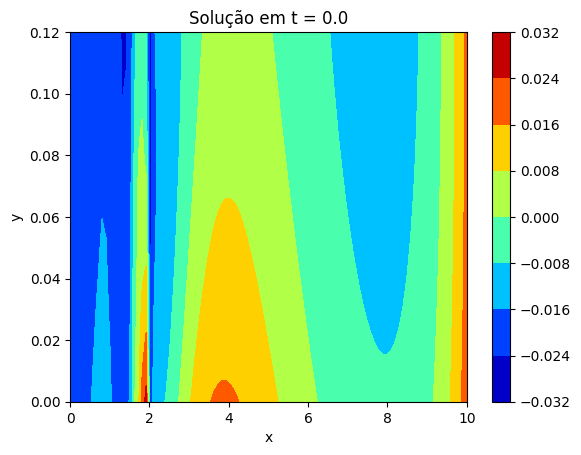

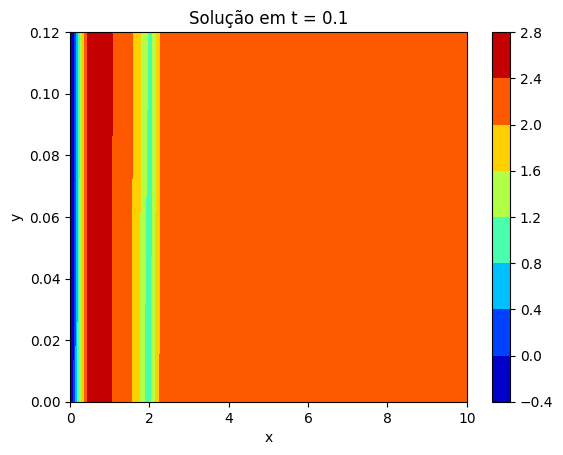

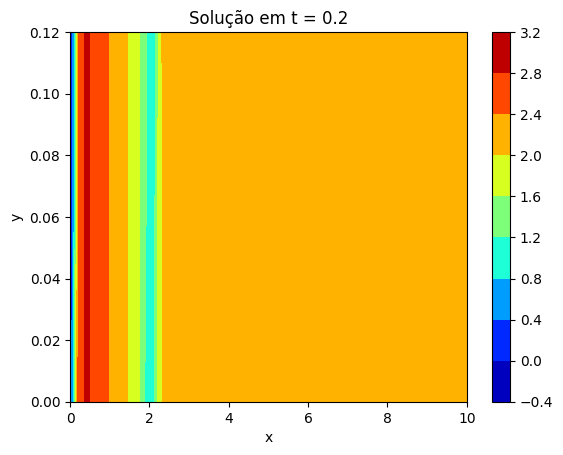

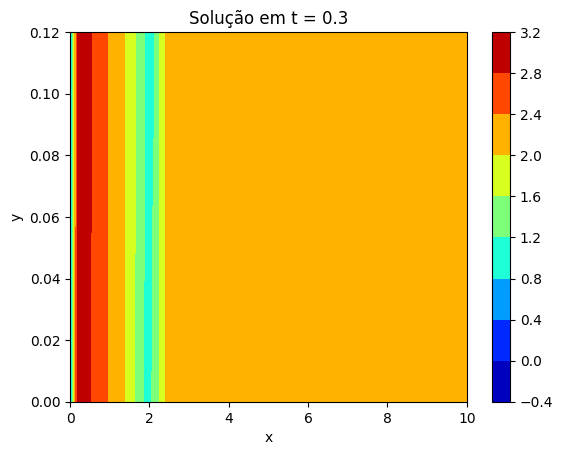

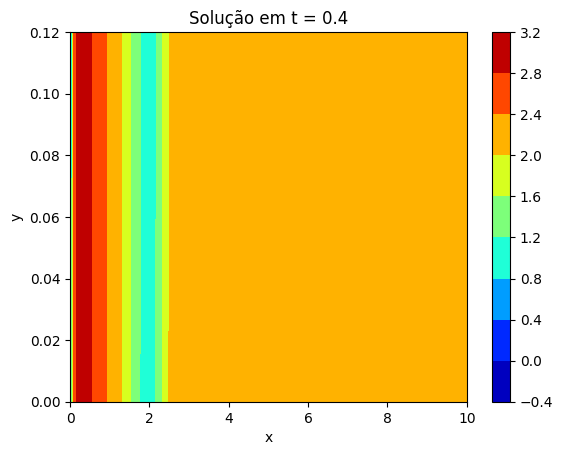

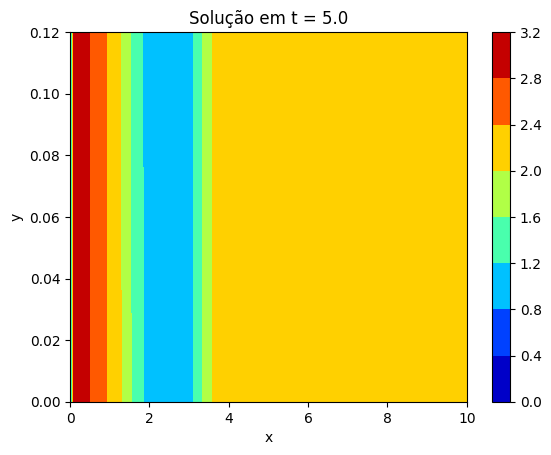

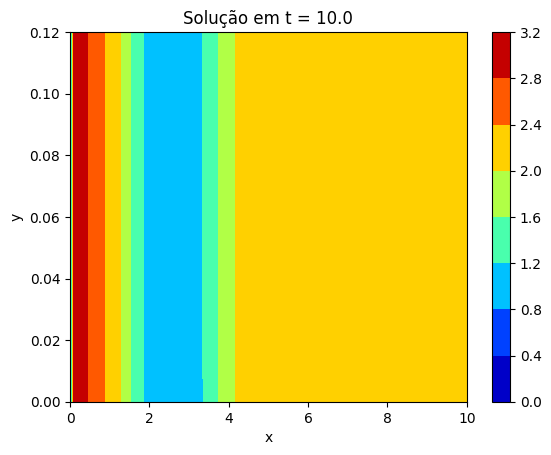

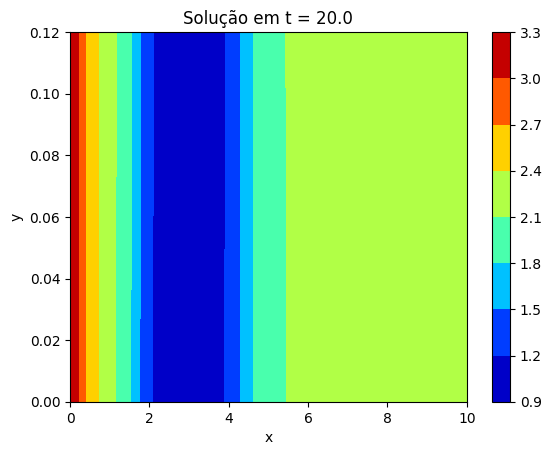

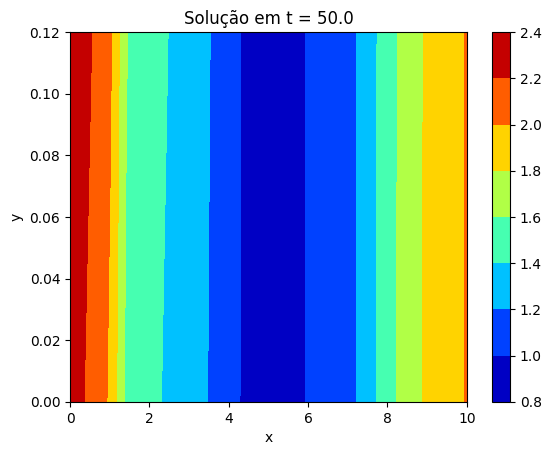

In [34]:
import numpy as np

# Definir uma função para avaliar a rede em diferentes instantes de tempo
def evaluate_solution(params, t_values, x_range, y_range, num_points=100):
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.linspace(y_range[0], y_range[1], num_points)
    X, Y = np.meshgrid(x, y)

    for t in t_values:
        T = np.full_like(X, t)  # Criar um array de tempo fixo
        input_data = np.column_stack([T.flatten(), X.flatten(), Y.flatten()])
        output = fwd(params, input_data[:, [1]], input_data[:, [2]], input_data[:, [0]])[:,[0]]  # Avaliar a rede
        solution = output.reshape(X.shape)

        # Plotar a solução (opcional)
        plt.figure()
        plt.contourf(X, Y, solution, cmap='jet')
        plt.colorbar()
        plt.title(f'Solução em t = {t}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

# Avaliar a solução para instantes de tempo
evaluate_solution(params, t_values=[0.0, 0.1, 0.2, 0.3, 0.4, 5.0, 10.0, 20.0, 50.0], x_range=(0, 10), y_range=(0, 0.12))

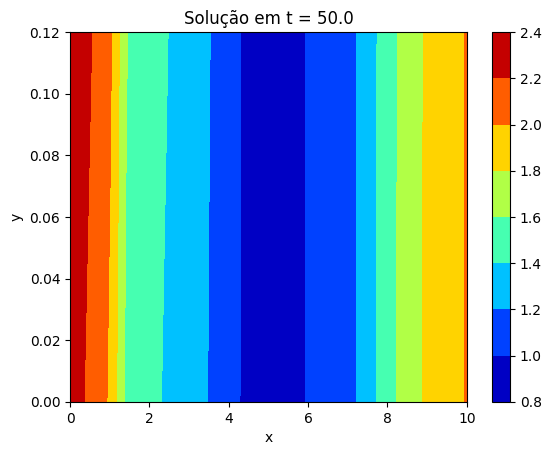

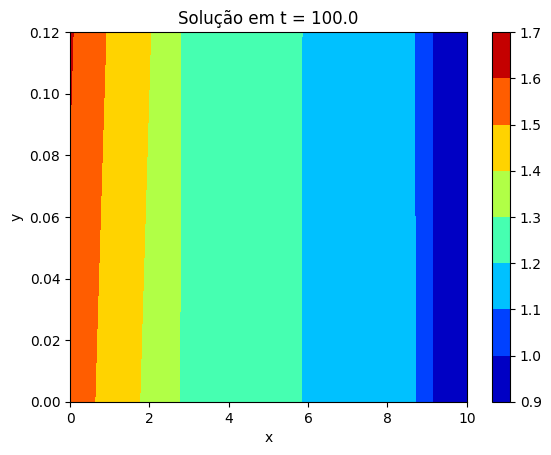

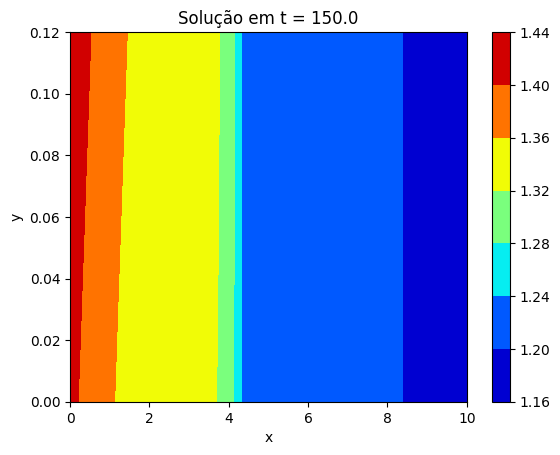

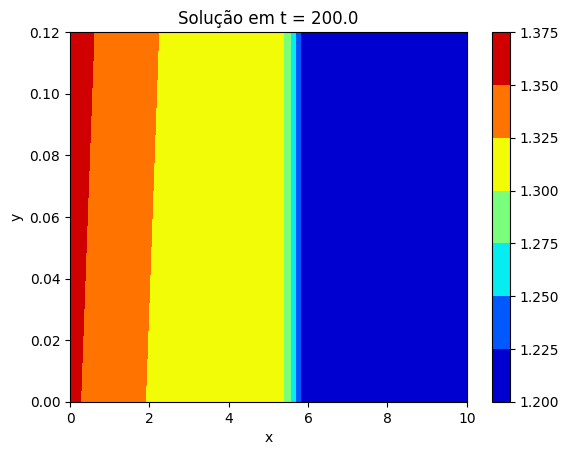

In [35]:
  import numpy as np

# Definir uma função para avaliar a rede em diferentes instantes de tempo
def evaluate_solution(params, t_values, x_range, y_range, num_points=100):
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.linspace(y_range[0], y_range[1], num_points)
    X, Y = np.meshgrid(x, y)

    for t in t_values:
        T = np.full_like(X, t)  # Criar um array de tempo fixo
        input_data = np.column_stack([T.flatten(), X.flatten(), Y.flatten()])
        output = fwd(params, input_data[:, [1]], input_data[:, [2]], input_data[:, [0]])[:,[0]]  # Avaliar a rede
        solution = output.reshape(X.shape)

        # Plotar a solução (opcional)
        plt.figure()
        plt.contourf(X, Y, solution, cmap='jet')
        plt.colorbar()
        plt.title(f'Solução em t = {t}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

# Avaliar a solução para instantes de tempo t = 0.1, 0.5 e 1.0
evaluate_solution(params, t_values=[50.0, 100., 150., 200.], x_range=(0, 10), y_range=(0, 0.12))

In [5]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax
from functools import partial

# --- Configuração do Domínio e Pontos ---
N_b = 400   # Número de pontos de contorno
N_r = 20000 # Pontos de colocação (resíduo da EDP)

# Limites do domínio [x, y, t]
lb = jnp.array([0., 0., 0.])
ub = jnp.array([10., 0.12, 10.])
xmin, ymin, tmin = lb
xmax, ymax, tmax = ub

# Chave para geração de números aleatórios
key = jax.random.PRNGKey(0)

# --- Parâmetros Físicos ---
Difu = 7.48e-3
rhoagua = 1000.
rhomeg = 1200.
visccinagua = 0.89e-3
visccinmeg = 16.1e-3
u_inlet = 2.21
p_initial = 10.0
p_outlet = 0.0
v_inj = 5e-3
p_inj = 7.0

In [6]:
# Dividindo a chave para garantir aleatoriedade diferente em cada conjunto
keys = jax.random.split(key, 20)

# 1. Pontos de Colocação (onde a EDP deve ser zero)
x_c = jax.random.uniform(keys[0], (N_r, 1), minval=xmin, maxval=xmax)
y_c = jax.random.uniform(keys[1], (N_r, 1), minval=ymin, maxval=ymax)
t_c = jax.random.uniform(keys[2], (N_r, 1), minval=tmin, maxval=tmax)
colloc = jnp.concatenate([x_c, y_c, t_c], axis=1)

# 2. Pontos de Condição Inicial (t=0)
x0 = jax.random.uniform(keys[3], (N_b, 1), minval=xmin, maxval=xmax)
y0 = jax.random.uniform(keys[4], (N_b, 1), minval=ymin, maxval=ymax)
espaco0 = jnp.concatenate([x0, y0, jnp.zeros_like(x0)], axis=1)
# Valores alvo para a condição inicial
c0_vals = jnp.zeros_like(x0)
u0_vals = jnp.full_like(x0, u_inlet)
v0_vals = jnp.zeros_like(x0)
p0_vals = jnp.full_like(x0, p_initial)

# 3. Pontos de Contorno (BC)
# Entrada (x=0)
t_in = jax.random.uniform(keys[5], (N_b, 1), minval=tmin, maxval=tmax)
y_in = jax.random.uniform(keys[6], (N_b, 1), minval=ymin, maxval=ymax)
espaco_in = jnp.concatenate([jnp.zeros_like(y_in), y_in, t_in], axis=1)
c_in_vals = jnp.zeros_like(y_in)
u_in_vals = jnp.full_like(y_in, u_inlet)
v_in_vals = jnp.zeros_like(y_in)

# Saída (x=Lx) --- NOVO ---
t_out = jax.random.uniform(keys[7], (N_b, 1), minval=tmin, maxval=tmax)
y_out = jax.random.uniform(keys[8], (N_b, 1), minval=ymin, maxval=ymax)
espaco_out = jnp.concatenate([jnp.full_like(y_out, xmax), y_out, t_out], axis=1)
p_out_vals = jnp.full_like(y_out, p_outlet) # p=0 na saída

# Paredes (y=0 e y=Ly) --- NOVO ---
t_wall = jax.random.uniform(keys[9], (N_b, 1), minval=tmin, maxval=tmax)
x_wall = jax.random.uniform(keys[10], (N_b, 1), minval=xmin, maxval=xmax)
espaco_wall_bottom = jnp.concatenate([x_wall, jnp.zeros_like(x_wall), t_wall], axis=1)
espaco_wall_top = jnp.concatenate([x_wall, jnp.full_like(x_wall, ymax), t_wall], axis=1)
uv_wall_vals = jnp.zeros_like(x_wall) # u=0 e v=0 (no-slip)

# 4. Pontos de Injeção
t_inj = jax.random.uniform(keys[11], (N_b//2, 1), minval=tmin, maxval=tmax)
x_inj_pts = jnp.full_like(t_inj, 2.0)
espaco_inj_bottom = jnp.concatenate([x_inj_pts, jnp.zeros_like(t_inj), t_inj], axis=1)
espaco_inj_top = jnp.concatenate([x_inj_pts, jnp.full_like(t_inj, ymax), t_inj], axis=1)
espaco_inj = jnp.concatenate([espaco_inj_bottom, espaco_inj_top], axis=0)
c_inj_vals = jnp.ones((N_b,1))
u_inj_vals = jnp.zeros((N_b,1))
v_inj_vals = jnp.full((N_b,1), v_inj)
p_inj_vals = jnp.full((N_b,1), p_inj)

In [7]:
# Definição da Rede Neural (MLP)
layers = [3, 128, 128, 128, 128, 4] # [x,y,t] -> [c,u,v,p]

def init_params(layers, key):
    params = []
    keys = jax.random.split(key, len(layers) - 1)
    for i, (n_in, n_out) in enumerate(zip(layers[:-1], layers[1:])):
        W = jax.random.normal(keys[i], (n_in, n_out)) * jnp.sqrt(2. / n_in)
        B = jnp.zeros(n_out)
        params.append({'W': W, 'B': B})
    return params

def fwd(params, x, y, t):
    X = jnp.concatenate([x, y, t], axis=1)
    # Normalização da entrada - crucial para bom desempenho
    X = 2.0 * (X - lb) / (ub - lb) - 1.0
    for layer in params[:-1]:
        X = jax.nn.tanh(X @ layer['W'] + layer['B'])
    return X @ params[-1]['W'] + params[-1]['B']

# Função para o resíduo da EDP (pode usar a sua 'PDE_loss' aqui)
# Por simplicidade, vamos assumir que a função 'PDE_loss' que você já tinha está definida
def PDE_loss(x, y, t, c_meg, u, v, p):
    # (Cole sua função PDE_loss original aqui)
    # ... por brevidade, vamos retornar um valor simbólico
    c_meg_t = jax.grad(lambda t: jnp.sum(c_meg(x,y,t)), 0)(t)
    # ... adicione todas as outras derivadas e equações
    # Este é um placeholder, use sua implementação completa
    return c_meg_t - 0.01 * jax.grad(lambda x: jnp.sum(jax.grad(lambda x: jnp.sum(c_meg(x,y,t)),0)(x)),0)(x)

In [8]:
def MSE(true, pred):
    return jnp.mean((true - pred)**2)

@jax.jit
def loss_fun(params, batch_data):
    # Desempacota todos os dados
    colloc, espaco0, espaco_in, espaco_out, espaco_wall_b, espaco_wall_t, espaco_inj = batch_data

    # Define as funções da rede e suas derivadas para facilitar a leitura
    # (Esta é a forma mais legível de fazer o que você já estava fazendo)
    def net(x, y, t): return fwd(params, x, y, t)
    c_net = lambda x,y,t: net(x,y,t)[:,[0]]
    u_net = lambda x,y,t: net(x,y,t)[:,[1]]
    v_net = lambda x,y,t: net(x,y,t)[:,[2]]
    p_net = lambda x,y,t: net(x,y,t)[:,[3]]

    # Derivadas para condições de contorno de Neumann (gradiente zero)
    u_x = lambda x,y,t: jax.grad(lambda x: jnp.sum(u_net(x,y,t)), 0)(x)
    v_x = lambda x,y,t: jax.grad(lambda x: jnp.sum(v_net(x,y,t)), 0)(x)
    c_x = lambda x,y,t: jax.grad(lambda x: jnp.sum(c_net(x,y,t)), 0)(x)

    # 1. Perda da EDP (Resíduo nos pontos de colocação)
    loss_r = MSE(0, PDE_loss(colloc[:,[0]], colloc[:,[1]], colloc[:,[2]], c_net, u_net, v_net, p_net))

    # 2. Perda da Condição Inicial (t=0)
    c0_pred, u0_pred, v0_pred, p0_pred = jnp.split(net(espaco0[:,[0]], espaco0[:,[1]], espaco0[:,[2]]), 4, axis=1)
    loss_ic = MSE(c0_vals, c0_pred) + MSE(u0_vals, u0_pred) + MSE(v0_vals, v0_pred) + MSE(p0_vals, p0_pred)

    # 3. Perda da Condição de Entrada (x=0)
    c_in_pred, u_in_pred, v_in_pred, _ = jnp.split(net(espaco_in[:,[0]], espaco_in[:,[1]], espaco_in[:,[2]]), 4, axis=1)
    loss_inlet = MSE(c_in_vals, c_in_pred) + MSE(u_in_vals, u_in_pred) + MSE(v_in_vals, v_in_pred)

    # 4. Perda da Condição de Saída (x=Lx) --- NOVO ---
    _, u_out_pred, v_out_pred, p_out_pred = jnp.split(net(espaco_out[:,[0]], espaco_out[:,[1]], espaco_out[:,[2]]), 4, axis=1)
    loss_outlet = MSE(p_out_vals, p_out_pred) #+ \
                  #MSE(0, u_x(espaco_out[:,[0]], espaco_out[:,[1]], espaco_out[:,[2]])) + \
                  #MSE(0, v_x(espaco_out[:,[0]], espaco_out[:,[1]], espaco_out[:,[2]])) + \
                  #MSE(0, c_x(espaco_out[:,[0]], espaco_out[:,[1]], espaco_out[:,[2]]))

    # 5. Perda nas Paredes (y=0, y=Ly) --- NOVO ---
    _, u_wall_b_pred, v_wall_b_pred, _ = jnp.split(net(espaco_wall_b[:,[0]], espaco_wall_b[:,[1]], espaco_wall_b[:,[2]]), 4, axis=1)
    _, u_wall_t_pred, v_wall_t_pred, _ = jnp.split(net(espaco_wall_t[:,[0]], espaco_wall_t[:,[1]], espaco_wall_t[:,[2]]), 4, axis=1)
    loss_wall = MSE(uv_wall_vals, u_wall_b_pred) + MSE(uv_wall_vals, v_wall_b_pred) + \
                MSE(uv_wall_vals, u_wall_t_pred) + MSE(uv_wall_vals, v_wall_t_pred)

    # 6. Perda na Injeção
    c_inj_pred, u_inj_pred, v_inj_pred, p_inj_pred = jnp.split(net(espaco_inj[:,[0]], espaco_inj[:,[1]], espaco_inj[:,[2]]), 4, axis=1)
    loss_inj = MSE(c_inj_vals, c_inj_pred) + MSE(u_inj_vals, u_inj_pred) + \
               MSE(v_inj_vals, v_inj_pred) + MSE(p_inj_vals, p_inj_pred)

    # Perda total com pesos (ajuste os pesos para priorizar certas perdas se necessário)
    loss_total = 1.0 * loss_r + 10.0 * loss_ic + 10.0 * (loss_inlet + loss_outlet + loss_wall) + 20.0 * loss_inj
    return loss_total